In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import numpy as np
import geopandas as gpd

## Create linkage matrix from data

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'

In [3]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          # 'licBAD',
    # 'misBAD',
    # 'ssbCCM','ssbCCD'    
]



linkage = 'ward'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [4]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)

    return component_data

In [5]:
region_id = 69333

In [6]:
from sklearn.preprocessing import QuantileTransformer
scalar = QuantileTransformer(subsample=None)
component_data = read_region_morphotope_data(region_id, scalar)

processing 69333


In [7]:
%%time
linkage = 'ward'
metric = 'euclidean'

from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
clusterer = AgglomerativeClustering(linkage=linkage,
                                    metric=metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(component_data.values)
linkage_matrix = get_linkage_matrix(model)

CPU times: user 551 ms, sys: 48.9 ms, total: 600 ms
Wall time: 600 ms


In [8]:
import sys
sys.setrecursionlimit(10000)

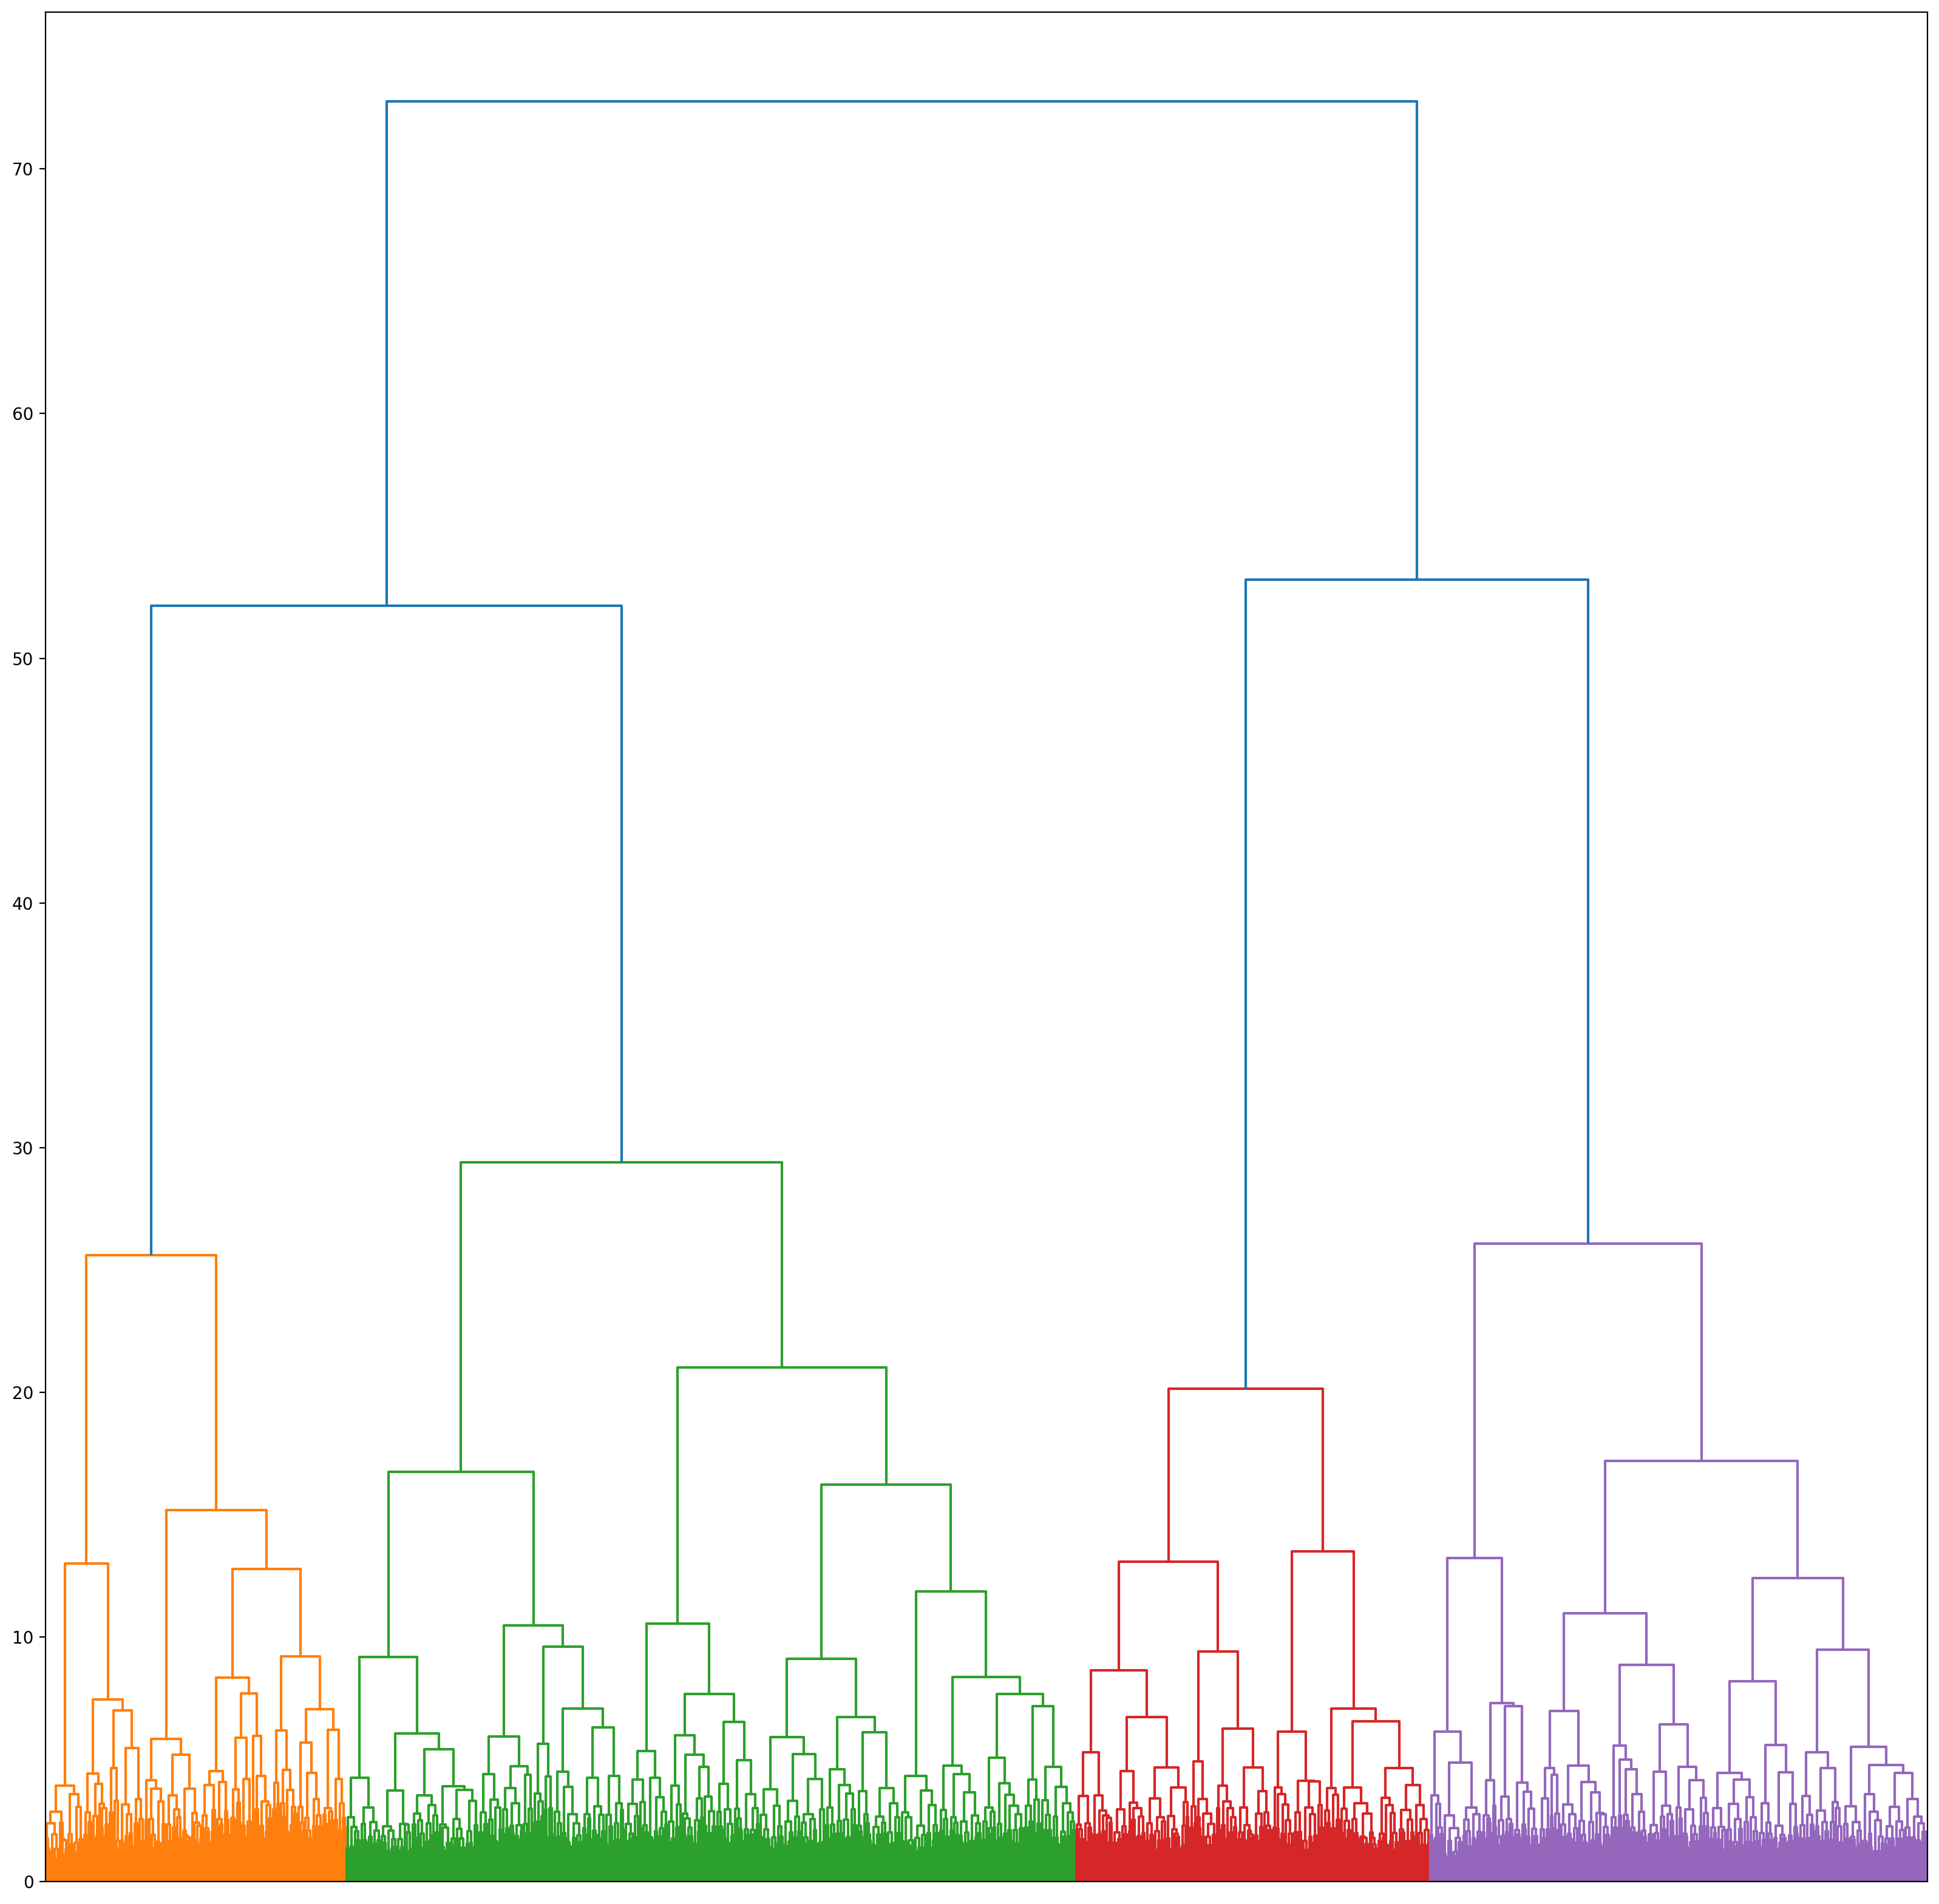

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

## Interactive dendroram

In [403]:
def get_dendrogram_scatter_data(linkage_matrix):
    
    R = dendrogram(linkage_matrix, no_plot=True)
    xs = np.array(R['icoord'])[:, 1:3].sum(axis=1)
    ys = np.array(R['dcoord'])[:, 1]

    ### fast way to find out where in ii, each node is equivalent to np.nonzero(ii == j)
    ii = np.argsort(ys)
    sorter = np.argsort(ii)
    positions = sorter[np.searchsorted(ii, np.arange(0, len(R['dcoord'])), sorter=sorter)]
    nodes = linkage_matrix[positions, ] 

    ## group for lines
    n = component_data.shape[0]
    line_groups = np.zeros(linkage_matrix.shape[0])
    line_orders = np.zeros(linkage_matrix.shape[0])
    for i in range(linkage_matrix.shape[0]-1, 0, -1):
        
        if line_groups[i] != 0: continue
            
        child, parent = linkage_matrix[i, 0].astype(int), linkage_matrix[i, 1].astype(int)
        line_groups[i] = i
        line_orders[i] = 2
        if child >= n:
            line_groups[child - n] = i
            line_orders[child - n] = 3
        if parent >= n:
            line_groups[parent - n] = i
            line_orders[parent - n] = 1
    
    scatter_df = pd.DataFrame(nodes, columns=['child', 'parent', 'dist', 'size'])
    scatter_df['x'] = xs
    scatter_df['y'] = ys
    scatter_df['group1'] = line_groups[positions].astype('str')
    scatter_df['order1'] = line_orders[positions].astype(int)

    ## double the data, in order to plot lines
    nodes = linkage_matrix[positions, ] 
    n = component_data.shape[0]
    line_groups = np.zeros(linkage_matrix.shape[0])
    line_orders = np.zeros(linkage_matrix.shape[0])
    for i in range(linkage_matrix.shape[0]-2, 0, -1):
        
        if line_groups[i] != 0: continue
            
        child, parent = linkage_matrix[i, 0].astype(int), linkage_matrix[i, 1].astype(int)
        line_groups[i] = i
        line_orders[i] = 2
        if child >= n:
            line_groups[child - n] = i
            line_orders[child - n] = 3
        if parent >= n:
            line_groups[parent - n] = i
            line_orders[parent - n] = 1
    
    scatter_df2 = pd.DataFrame(nodes, columns=['child', 'parent', 'dist', 'size'])
    scatter_df2['x'] = xs
    scatter_df2['y'] = ys
    scatter_df2['group1'] = line_groups[positions].astype('str')
    scatter_df2['order1'] = line_orders[positions].astype(int)
    
    return pd.concat((scatter_df, scatter_df2), ignore_index=True)

In [404]:
scatter_df = get_dendrogram_scatter_data(linkage_matrix)

In [405]:
linkage_matrix[5273 - component_data.shape[0]]

array([5263.        , 5267.        ,   25.60010633,  422.        ])

In [406]:
linkage_matrix[5275 - component_data.shape[0]]

array([5269.        , 5272.        ,   29.39539693, 1024.        ])

In [407]:
import jscatter
import ipywidgets

In [408]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', height=640, width=1280)
scatter.axes(grid=True)

output = ipywidgets.Output()

@output.capture(clear_output=True)
def selection_change_handler(change):
    display(scatter_df.loc[change.new].style.hide(axis='index'))
            
scatter.widget.observe(selection_change_handler, names=["selection"])

ipywidgets.HBox([scatter.show(), output])


In [409]:
scatter.connect(by='group1', order='order1')

In [412]:

def zoom_to_label_target(target_morphotope, component_data, scatter_df, scatter, selection=False):
    target_morphotope_idx = np.where(component_data.index == target_morphotope)[0][0]
    target_scatter_node = np.where((scatter_df['child'] == target_morphotope_idx) | (scatter_df['parent'] == target_morphotope_idx))
    scatter.zoom([target_scatter_node])
    if selection:
        scatter.selection(target_scatter_node)

import numpy as np

def get_original_observations(Z, node_id, n):
    """
    Recursively retrieves all original observations that belong to a cluster node.

    Parameters:
    Z : numpy.ndarray
        Linkage matrix of shape (n-1, 4) where each row [Z[i, 0], Z[i, 1], Z[i, 2], Z[i, 3]]
        contains two merged clusters and additional metadata.
    node_id : int
        The node (cluster) ID for which to retrieve original observations.
    n : int
        The total number of original observations.

    Returns:
    observations : list
        List of original observation indices that are part of the specified node_id.
    """
    # If the node_id refers to an original observation, return it
    if node_id < n:
        return [node_id]
    
    # Otherwise, recursively find observations for the two merged clusters
    cluster_idx = node_id - n # Adjust the index because new clusters start from n
    
    left_cluster = int(Z[cluster_idx, 0])
    right_cluster = int(Z[cluster_idx, 1])
    
    left_observations = get_original_observations(Z, left_cluster, n)
    right_observations = get_original_observations(Z, right_cluster, n)
    
    return left_observations + right_observations

def get_children(left, right):
    res1 = get_original_observations(linkage_matrix, left, component_data.shape[0])
    res2 = get_original_observations(linkage_matrix, right, component_data.shape[0])
    res = np.union1d(res1, res2)
    return res



# def dendogram_idx_nodes(idx, node_id, linkage, n_children, out=[]):
    
#     if node_id < 0:
#        return
#     left, right = linkage[idx]
#     out.append((idx, node_id))
#     # recurse over the right node
#     if right >= n_children: # make sure it's not a leaf node
#         node_id -= 1
#         node_id = dendogram_idx_nodes(right - (n_children + 1), node_id,
#                                      linkage, n_children, out)
#     if left >= n_children: # make sure it's not a leaf node
#         node_id -= 1
#         node_id = dendogram_idx_nodes(left - (n_children +1), node_id,
#                                      linkage, n_children, out)
#     return node_id

In [413]:
target_morphotope = '69333_849_104'

In [414]:
zoom_to_label_target(target_morphotope, component_data, scatter_df, scatter)


In [415]:
selected_node = scatter.selection()[0]
children_ids = get_children(scatter_df.loc[selected_node, 'child'].astype(int), scatter_df.loc[selected_node, 'parent'].astype(int))
children_morphotopes = component_data.iloc[children_ids].index

In [416]:
# etcs[etcs.morph.isin(children_morphotopes)].explore(prefer_canvas=True, tiles='CartoDB positron')

In [418]:
region_id = 69333


etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['morph'] = "-1"

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]
etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values

In [419]:
## test that get children works
assert get_children(int(linkage_matrix[123, 0]), int(linkage_matrix[123, 1])).shape[0] == linkage_matrix[123, 3]
assert get_children(int(linkage_matrix[321, 0]), int(linkage_matrix[321, 1])).shape[0] == linkage_matrix[321, 3]
assert get_children(int(linkage_matrix[-1, 0]), int(linkage_matrix[-1, 1])).shape[0] == linkage_matrix[-1, 3]

In [420]:
pd.Series(linkage_matrix[:, 2]).describe()

count    2639.000000
mean        1.965416
std         2.584853
min         0.340323
25%         1.208224
50%         1.492992
75%         2.000185
max        72.772105
dtype: float64

In [29]:
cutoff = 20

kmeans_clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')


In [30]:
# ward_clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
# ward_clusters = pd.Series(ward_clusters, index=np.arange(np.unique(kmeans_clusters).shape[0]))
# np.unique(ward_clusters)

In [31]:
# clusters = pd.Series(kmeans_clusters).map(lambda x: ward_clusters.loc[x]).values

In [24]:
clusters = kmeans_clusters.copy()

In [25]:
region_id = 4


etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['label'] = -1

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  str(region_id) + '_' + morphotopes.values[:, 0]

region_clusters = pd.Series(clusters, component_data.index)
region_clusters

4_0_-1     187
4_0_0      562
4_0_1       43
4_0_10     155
4_0_11      82
          ... 
4_99_96     69
4_99_97    263
4_99_98    263
4_99_99    217
4_9_-1     511
Length: 74145, dtype: int32

In [26]:
region_clusters.nunique()

1076

In [27]:
region_clusters.value_counts()

109     418
108     366
257     342
115     341
86      334
       ... 
47        1
926       1
1071      1
932       1
1069      1
Name: count, Length: 1076, dtype: int64

In [28]:
%%time
## assign morphotope clusters to tess cells

etcs.loc[morphotopes.index, 'label'] = morphotopes.morphotope_label.map(lambda x: region_clusters.loc[x] if x in region_clusters.index else -1).values


CPU times: user 24.5 s, sys: 330 ms, total: 24.8 s
Wall time: 24.6 s


In [29]:
# %%time
# # # # relabel morphotopes for plotting
# morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
#                        np.unique(morphotopes.values))
# etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
# etcs['morph'] = '-1'
# etcs.loc[morphotopes.index, 'morph'] = morphotopes.values

In [35]:
etcs.label.value_counts()

label
184     440385
112     243933
109      86622
115      71529
108      71445
         ...  
931          1
1064         1
1070         1
59           1
268          1
Name: count, Length: 1077, dtype: int64

In [36]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)

In [58]:
etcs = etcs.to_crs(epsg=4326)

In [59]:

etcs['geometry'] = etcs.geometry.make_valid()

In [ ]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.08)

In [ ]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [ ]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)